In [1]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [2]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [3]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [4]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [5]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()


In [6]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [21]:
def DP_LSTM(company, df):
  # Adding noise to dataset
  # calculating the variance of the mean_compound column
  news_column  = 'mean_compound'
  mc_var=np.var(df.mean_compound)
  mu=0
  noise=0.1
  sigma_noise = noise*mc_var
  n = df.shape[0]
  # create a dataframe for noise
  df_noise = pd.DataFrame()
  df_noise['mc_noise'] = df[news_column]
  for i in range(0,n):
      df_noise['mc_noise'][i]+=np.random.normal(mu,sigma_noise)  
  noise_name = "mc_noise_"+company+".csv"    
  df_noise.to_csv(noise_name)
  dfn = pd.read_csv(noise_name,index_col=0)
  # creating one dataframe by adding noise in news columns 
  df1 = pd.DataFrame()
  df1['price'] = df['adj_close']
  df1['mc'] = dfn['mc_noise']
  # creating another dataframe by adding normal noise column 
  df2 = pd.DataFrame()
  df2['price'] = df['adj_close']
  df2['mc'] = df['mean_compound']

  # choosing columns for the model
  cols = ['price','mc']
  # deciding the split size
  split = 0.85
  sequence_length=10;
  split_index = int(len(df1) * split)
  data_train1 = df1.get(cols).values[:split_index]
  data_train2 = df2.get(cols).values[:split_index]
  train_len  = len(data_train1)
  train_windows_len = None

  # Normalizing Train data1
  data_windows1 = create_windows(data_train1,train_len,sequence_length)
  normalized_data1,rmax_t1, rmin_t1 = Normalize_data(data_windows1)

  x_train1 = normalized_data1[:, :-1]
  y_train1 = normalized_data1[:, -1,[0]]

  # Normalizing Train data2
  data_windows2 = create_windows(data_train2, train_len,sequence_length)
  normalized_data2,rmax_t2, rmin_t2 = Normalize_data(data_windows2)

  x_train2 = normalized_data2[:, :-1]
  y_train2 = normalized_data2[:, -1,[0]]

  # concatenating the training data
  x_train = np.concatenate((x_train1,x_train2),axis=0)
  y_train = np.concatenate((y_train1,y_train2),axis=0)
  x_train.shape, y_train.shape

  #x_train = x_train1
  #y_train = y_train1

  # Creating the Test Data
  df_test = pd.read_csv(df_name, index_col = 0)
  df_test = df_test.rename(columns = {'adj_close': 'price','mean_compound':'mc'})
  #df_test['date'] = pd.to_datetime(df_test['date'])
  cols = ['price','mc']
  cols2 = ['date']
  test_len = df_test.shape[0]

  data_test  = df_test.get(cols).values[split_index:]
  data_test2  = df_test.get(cols2).values[split_index:]

  data_windows_test = create_windows(data_test, len(data_test), sequence_length)
  # the last price value of each window is the original y_test
  y_test_original = data_windows_test[:, -1, [0]]

  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]


  # Setting the parameters  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9
 
  # LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=40, batch_size=32)

  

  plot_training_loss(hist)
  #model_name = company+'_stock_predict_LSTM' 
  #model.save('saved_model/'+model_name)
  # Loading the model
  #model = tf.keras.models.load_model('saved_model/stock_predict_LSTM')

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  print(len(predicted_vals))
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)

  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")
  
  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [22]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
Epoch 1/40
141/141 [==============================] - 11s 52ms/step - loss: 0.2238 - mean_squared_error: 0.2238
Epoch 2/40
141/141 [==============================] - 7s 51ms/step - loss: 0.0828 - mean_squared_error: 0.0828
Epoch 3/40
141/141 [==============================] - 7s 51ms/step - loss: 0.0830 - mean_squared_error: 0.0830
Epoch 4/40
141/141 [==============================] - 7s 51ms/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 5/40
141/141 [==============================] - 7s 51ms/step - loss: 0.0772 - mean_squared_error: 0.0772
Epoch 6/40
141/141 [==============================] - 7s 52ms/step - loss: 0.0751 - mean_squared_error: 0.0751
Epoch 7/40
141/141 [==============================] - 7s 51ms/step - loss: 0.0731 - mean_squared_error: 0.0731
Epoch 8/40
141/141 [==============================] - 7s 51ms/step - loss: 0.0725 - mean_squared_error: 0.0725
Epoch 9/40
141/141 [==============================] - 7s 52ms/step - loss: 

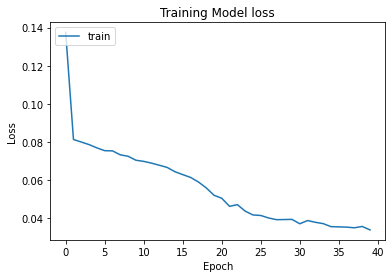

390
           date     Actual  Predicted
0    2018-07-27  47.023903  47.082128
1    2018-07-30  46.241833  46.893835
2    2018-07-31  45.982750  46.019807
3    2018-08-01  46.074760  46.213248
4    2018-08-02  48.789028  48.603625
..          ...        ...        ...
385  2020-02-07  80.486107  78.820255
386  2020-02-10  79.392090  79.270666
387  2020-02-11  79.769165  79.323957
388  2020-02-12  79.287888  79.319085
389  2020-02-13  81.170799  80.713989

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0421 - mean_squared_error: 0.0421
LSTM Model Loss =  [0.04206302389502525, 0.04206302389502525]
Model Accuracy =  99.14634407852225
Mean Absolute Error =  0.44612378028617755  degrees
Mean Squared Error =  0.36735600473252766
Root Mean Squared Error =  0.606099005718148

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
Epoch 1/40
141/141 [==============

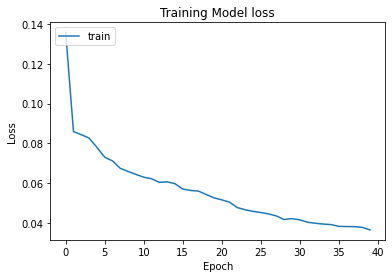

390
           date       Actual    Predicted
0    2018-07-27  1808.000000  1858.175814
1    2018-07-30  1817.270020  1835.387687
2    2018-07-31  1779.219971  1778.608264
3    2018-08-01  1777.439941  1794.970352
4    2018-08-02  1797.170044  1809.988306
..          ...          ...          ...
385  2020-02-07  2050.229980  2016.665848
386  2020-02-10  2079.280029  2050.182066
387  2020-02-11  2133.909912  2122.747781
388  2020-02-12  2150.800049  2131.400345
389  2020-02-13  2160.000000  2128.955043

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0366 - mean_squared_error: 0.0366
LSTM Model Loss =  [0.03660336881875992, 0.03660336881875992]
Model Accuracy =  99.19975499640452
Mean Absolute Error =  14.095191100393313  degrees
Mean Squared Error =  432.49567797141884
Root Mean Squared Error =  20.796530431094002

--------------------------------------------------------------------------

Evaluating Model for Co

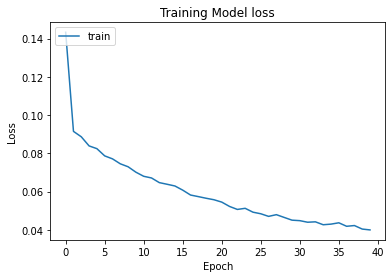

390
           date     Actual  Predicted
0    2018-07-27  43.653885  43.507422
1    2018-07-30  43.562386  43.549229
2    2018-07-31  43.324490  43.534096
3    2018-08-01  44.157127  44.224348
4    2018-08-02  44.019875  44.128499
..          ...        ...        ...
385  2020-02-07  44.165833  44.085205
386  2020-02-10  43.906483  43.880336
387  2020-02-11  43.877670  43.802195
388  2020-02-12  44.300312  43.830219
389  2020-02-13  44.155090  44.052033

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0396 - mean_squared_error: 0.0396
LSTM Model Loss =  [0.03960083797574043, 0.03960083797574043]
Model Accuracy =  99.44024462286615
Mean Absolute Error =  0.2280330763077772  degrees
Mean Squared Error =  0.1318122498541861
Root Mean Squared Error =  0.3630595679143935

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
Epoch 1/40
141/141 [===============

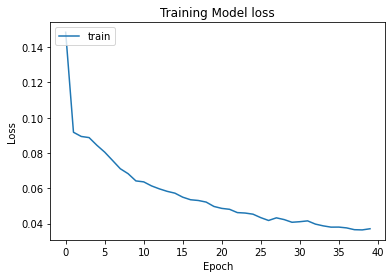

390
           date       Actual    Predicted
0    2018-07-27  1268.329956  1266.773860
1    2018-07-30  1238.500000  1262.550697
2    2018-07-31  1219.739990  1249.081797
3    2018-08-01  1217.260010  1235.116029
4    2018-08-02  1220.010010  1232.077279
..          ...          ...          ...
385  2020-02-07  1476.229980  1466.105919
386  2020-02-10  1479.229980  1474.311339
387  2020-02-11  1508.680054  1509.658653
388  2020-02-12  1508.790039  1506.475992
389  2020-02-13  1518.270020  1516.680718

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0480 - mean_squared_error: 0.0480
LSTM Model Loss =  [0.04801312834024429, 0.04801312834024429]
Model Accuracy =  99.29673536262317
Mean Absolute Error =  8.134307900582668  degrees
Mean Squared Error =  158.91282559846374
Root Mean Squared Error =  12.606063049122978

--------------------------------------------------------------------------

Evaluating Model for Com

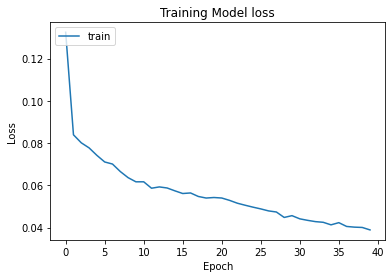

390
           date     Actual  Predicted
0    2018-07-27  33.331360  33.778242
1    2018-07-30  32.731140  33.956693
2    2018-07-31  32.595608  33.788451
3    2018-08-01  32.382629  33.412011
4    2018-08-02  32.034122  32.048987
..          ...        ...        ...
385  2020-02-07  37.343075  37.047568
386  2020-02-10  35.574196  36.721489
387  2020-02-11  35.397308  36.142730
388  2020-02-12  35.810051  35.849274
389  2020-02-13  36.507778  35.842151

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0348 - mean_squared_error: 0.0348
LSTM Model Loss =  [0.034842707216739655, 0.034842707216739655]
Model Accuracy =  99.30862839984603
Mean Absolute Error =  0.23466098688706985  degrees
Mean Squared Error =  0.11413845195835493
Root Mean Squared Error =  0.337843827764183

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
Epoch 1/40
141/141 [=============

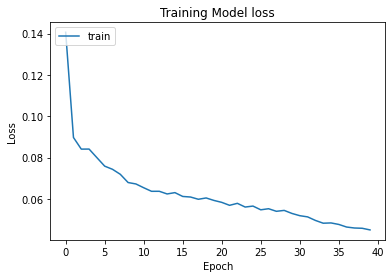

390
           date     Actual  Predicted
0    2018-07-27  71.726852  71.479230
1    2018-07-30  69.751480  71.367997
2    2018-07-31  69.598213  70.679769
3    2018-08-01  69.402374  70.276337
4    2018-08-02  68.448746  68.412931
..          ...        ...        ...
385  2020-02-07  56.346684  56.693598
386  2020-02-10  55.973351  56.241673
387  2020-02-11  55.382210  56.595175
388  2020-02-12  55.908691  56.353341
389  2020-02-13  56.592194  56.654239

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0374 - mean_squared_error: 0.0374
LSTM Model Loss =  [0.03735724836587906, 0.03735724836587906]
Model Accuracy =  99.4409095346346
Mean Absolute Error =  0.36923497855748716  degrees
Mean Squared Error =  0.26127490258184644
Root Mean Squared Error =  0.5111505674278827

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
Epoch 1/40
141/141 [===============

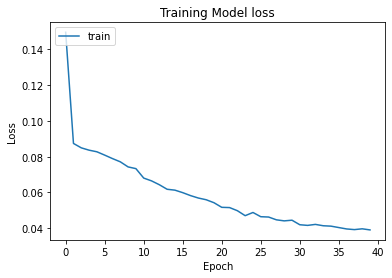

390
           date     Actual  Predicted
0    2018-07-27  63.071827  62.729401
1    2018-07-30  62.687599  62.530513
2    2018-07-31  62.601139  62.488417
3    2018-08-01  62.956558  62.542650
4    2018-08-02  62.226517  62.474558
..          ...        ...        ...
385  2020-02-07  88.100525  87.515115
386  2020-02-10  86.525017  87.581217
387  2020-02-11  86.948433  87.080298
388  2020-02-12  87.805115  87.198575
389  2020-02-13  87.430931  87.285784

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0503 - mean_squared_error: 0.0503
LSTM Model Loss =  [0.050273776054382324, 0.050273776054382324]
Model Accuracy =  99.34028255102831
Mean Absolute Error =  0.4916276744038108  degrees
Mean Squared Error =  0.47501476292908673
Root Mean Squared Error =  0.6892131476757294

--------------------------------------------------------------------------



In [23]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = DP_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)
  

In [26]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.446124,0.367356,99.146344,0.606099
1,AMZN,14.095191,432.495678,99.199755,20.796530
2,ADM,0.228033,0.131812,99.440245,0.363060
3,GOOG,8.134308,158.912826,99.296735,12.606063
4,EBAY,0.234661,0.114138,99.308628,0.337844
5,XOM,0.369235,0.261275,99.440910,0.511151
6,ABT,0.491628,0.475015,99.340283,0.689213


In [27]:
# Mean Accuracy for DP-LSTM
mean_results = company_results.mean(axis = 0)
mean_results

MAE          3.428454
MSE         84.679729
Accuracy    99.310414
RMSE         5.129994
dtype: float64

In [29]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P3_LSTM_All_Companies_dplstm"+current_time+".csv"
company_results.to_csv(name)